- **Author:** ` Kandimalla Hemanth`
- **✉:** speechcodehemanth2@gmail.com

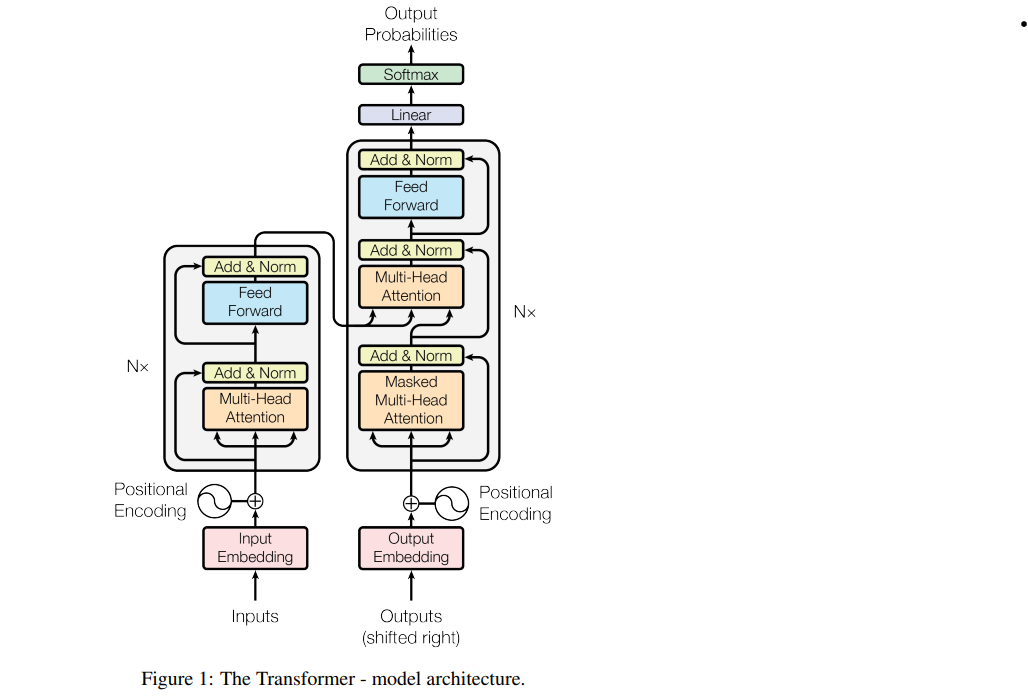

# Understanding the Transformer Model

## The Transformer Encoder-Decoder [Vaswani et al., 2017]

The Transformer is a neural network architecture introduced in the seminal paper "Attention Is All You Need" that revolutionized sequence-to-sequence tasks by eliminating recurrence and convolutions entirely. Instead, it relies solely on attention mechanisms to draw global dependencies between input and output.

**Definition**: The Transformer is a deep learning model that uses self-attention mechanisms to process sequential data in parallel rather than sequentially, enabling more efficient computation and better modeling of long-range dependencies.

**Core Equation**: The overall Transformer function can be described as:

$$y = \text{Transformer}(x) = \text{Decoder}(\text{Encoder}(x))$$

Where $x$ is the input sequence and $y$ is the output sequence.

## Encoder: Self-Attention

### Intuition for Attention Mechanism

Attention allows the model to focus on relevant parts of the input sequence when producing each element of the output. Unlike RNNs which process tokens sequentially, attention considers all tokens simultaneously and weighs their importance for each position.

**Core Principle**: For each word in a sequence, attention calculates how much focus should be placed on every other word to better encode the current word's meaning and context.

### Recipe for Self-Attention in the Transformer Encoder

Self-attention computes a weighted sum of all positions in a sequence for each position.

1. For each word, create three vectors:
   - Query vector ($q$): What the word is looking for
   - Key vector ($k$): What the word offers to others
   - Value vector ($v$): The actual content of the word

2. Calculate attention scores between a word and all words in the sequence:
   
   $$\text{score}(q_i, k_j) = q_i \cdot k_j$$

3. Convert scores to probabilities using softmax:
   
   $$\alpha_{ij} = \frac{\exp(\text{score}(q_i, k_j))}{\sum_{l=1}^{n}\exp(\text{score}(q_i, k_l))}$$

4. Multiply each value vector by its attention weight and sum:
   
   $$\text{output}_i = \sum_{j=1}^{n}\alpha_{ij}v_j$$

### Recipe for (Vectorized) Self-Attention in the Transformer Encoder

For efficient computation, self-attention is implemented using matrix operations:

1. Project input matrix $X$ into query, key, and value matrices:
   
   $$Q = XW^Q, K = XW^K, V = XW^V$$
   
   Where $W^Q, W^K, W^V$ are learnable parameter matrices.

2. Compute attention scores matrix:
   
   $$S = QK^T$$

3. Apply softmax row-wise:
   
   $$A = \text{softmax}(\frac{S}{\sqrt{d_k}})$$

4. Compute output:
   
   $$Z = AV$$

### What We Have So Far: (Encoder) Self-Attention!

Self-attention enables the model to:
- Capture long-range dependencies regardless of distance
- Process all positions simultaneously (parallelization)
- Model complex relationships between tokens
- Achieve state-of-the-art performance on various NLP tasks

### But attention isn't quite all you need!

Despite its power, pure self-attention has limitations:
- Gradient vanishing/exploding in deep networks
- Lack of positional information
- Limited by computational complexity ($O(n^2)$ where $n$ is sequence length)

### Training Trick #1: Residual Connections

Residual connections allow gradients to flow directly through the network, mitigating the vanishing gradient problem.

**Mathematical Formulation**:

$$\text{output} = \text{LayerNorm}(x + \text{Sublayer}(x))$$

Where $\text{Sublayer}(x)$ is the function implemented by the sub-layer itself (attention or feed-forward network).

### Training Trick #2: Layer Normalization [Ba et al.]

Layer normalization stabilizes the training process by normalizing activations across features.

**Mathematical Formulation**:

$$\text{LayerNorm}(x) = \gamma \cdot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$$

Where:
- $\mu$ and $\sigma$ are mean and standard deviation computed over the feature dimension
- $\gamma$ and $\beta$ are learnable scale and shift parameters
- $\epsilon$ is a small constant for numerical stability

### Training Trick #3: Scaled Dot Product Attention

Scaling the dot products prevents softmax from entering regions with extremely small gradients when input dimension is large.

**Mathematical Formulation**:

$$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

Where $d_k$ is the dimension of key vectors.

### Solution: Inject Order Information through Positional Encodings!

Since self-attention has no inherent notion of token position, positional encodings are added to input embeddings to incorporate sequential information.

**Core Principle**: Positional encodings must:
- Be unique for each position
- Have consistent distance relationship between positions
- Be deterministic to allow extrapolation to longer sequences

### Position representation vectors through sinusoids (original)

The original Transformer uses sinusoidal functions to encode positions:

$$PE_{(pos, 2i)} = \sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)} = \cos(pos/10000^{2i/d_{model}})$$

Where:
- $pos$ is the position index
- $i$ is the dimension index
- $d_{model}$ is the embedding dimension

**Advantages**:
- Allows model to extrapolate to sequence lengths not seen during training
- Provides smooth transition between positions
- Encodes relative positions implicitly

### Extension: Self-Attention w/ Relative Position Encodings

Relative position encodings explicitly model the distance between tokens rather than absolute positions.

**Mathematical Formulation**:

$$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T + S_{rel}}{\sqrt{d_k}})V$$

Where $S_{rel}$ contains pairwise relative position information:

$$S_{rel_{ij}} = f(i-j)$$

$f$ is a function mapping relative positions to scalar values or vectors.

### Multi-Headed Self-Attention: k heads are better than one

Multiple attention heads allow the model to jointly attend to information from different representation subspaces.

**Mathematical Formulation**:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O$$

Where:

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

- $W_i^Q, W_i^K, W_i^V$ are parameter matrices for head $i$
- $W^O$ is a parameter matrix for combining heads

### The Transformer Encoder: Multi-headed Self-Attention

The complete Transformer encoder consists of:
1. Input embeddings + positional encodings
2. N identical layers, each containing:
   - Multi-head self-attention sub-layer
   - Position-wise fully connected feed-forward network (FFN)
   - Residual connections and layer normalization

**Feed-Forward Network**:

$$\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2$$

## Decoder: Masked Multi-Head Self-Attention

### Masking the future in self-attention

The decoder prevents positions from attending to subsequent positions by masking future tokens in the self-attention calculation.

**Mathematical Formulation**:

$$\text{MaskedAttention}(Q, K, V) = \text{softmax}(\frac{QK^T + M}{\sqrt{d_k}})V$$

Where:
- $M$ is a mask matrix with $M_{ij} = -\infty$ if $j > i$ (future position)
- $M_{ij} = 0$ otherwise

This ensures that prediction for position $i$ depends only on known outputs at positions less than $i$.

## Encoder-Decoder Attention

Encoder-decoder attention allows the decoder to focus on relevant parts of the input sequence:

1. Queries come from the previous decoder layer
2. Keys and values come from the encoder output

**Mathematical Formulation**:

$$\text{EncoderDecoderAttention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

Where:
- $Q$ is from the decoder layer
- $K$ and $V$ are from the encoder output

**Pros of Transformer Architecture**:
- Parallelizable computation (unlike RNNs)
- Captures long-range dependencies effectively
- State-of-the-art performance on various NLP tasks
- Scalable to large models and datasets

**Cons of Transformer Architecture**:
- Quadratic complexity with sequence length ($O(n^2)$)
- High memory requirements
- Requires large amounts of training data
- Positional encoding limitations for very long sequences

**Recent Advancements**:
- Efficient attention mechanisms (Linformer, Reformer, Performer)
- Pre-trained models (BERT, GPT, T5)
- Sparse attention patterns
- Transformer variants for different modalities (ViT for images, etc.)
- Length extrapolation methods
- Mixture of Experts architectures

# Scaling Laws in Deep Learning

## Definition

Scaling laws in deep learning refer to empirical relationships that describe how model performance improves as a function of model size, dataset size, and computational resources. For transformer-based language models, these relationships follow power-law patterns, indicating predictable improvements as resources scale up.

## Mathematical Formulation

### Core Power-Law Equations

The fundamental scaling law for language models as established by Kaplan et al. (2020) shows that loss $L$ decreases as a power-law with model parameters $N$, dataset size $D$, and compute budget $C$:

$$L(N) \approx \left(\frac{N_c}{N}\right)^{\alpha_N}$$

$$L(D) \approx \left(\frac{D_c}{D}\right)^{\alpha_D}$$

$$L(C) \approx \left(\frac{C_c}{C}\right)^{\alpha_C}$$

Where:
- $N_c$, $D_c$, and $C_c$ are constants
- $\alpha_N$, $\alpha_D$, and $\alpha_C$ are power-law exponents

For transformers, typical values are $\alpha_N \approx 0.076$, $\alpha_D \approx 0.095$, and $\alpha_C \approx 0.057$.

### Chinchilla Optimal Scaling

Hoffman et al. (2022) refined these laws, showing that the optimal parameter-to-data ratio follows:

$$N_{optimal} \propto D_{optimal}$$

Specifically, training tokens should scale approximately linearly with model parameters:

$$D_{optimal} \approx 20N_{optimal}$$

## Core Principles

### Mechanistic Basis

1. **Universal Approximation**: Larger models have greater representational capacity to approximate complex functions.
2. **Lottery Ticket Hypothesis**: Larger models contain more "winning lottery tickets" (effective subnetworks).
3. **Data Efficiency**: As models scale, they become more data-efficient, extracting more information per token.
4. **Self-Supervised Learning**: Pre-training objectives create increasingly useful representations with scale.

### Scale-Driven Phenomena

- **Emergent Abilities**: Capabilities that appear suddenly at certain scale thresholds
- **Grokking**: Delayed generalization that occurs after extended training at scale
- **In-Context Learning**: Improves predictably with scale, allowing few-shot learning

## Empirical Evidence

### Cross-Architecture Consistency

- Power-law scaling holds across architectures: Transformers, RNNs, and CNNs
- Exponents vary by architecture, with transformers showing the most favorable scaling properties
- Holds over 6+ orders of magnitude (from millions to trillions of parameters)

### Performance Metrics

For language models, perplexity on held-out data improves according to:

$$\text{Perplexity} \approx \exp(L) \approx \exp\left(A \cdot N^{-\alpha_N}\right)$$

Where $A$ is a constant and $\exp(L)$ denotes the exponential of the loss.

## Limitations and Criticisms

### Practical Constraints

- **Compute Costs**: Training and inference costs grow significantly with model size
- **Energy Consumption**: Environmental impact increases proportionally
- **Training Instability**: Larger models require more sophisticated optimization techniques

### Theoretical Limitations

- **Diminishing Returns**: Power laws imply diminishing returns per parameter added
- **Data Quality Ceiling**: Performance eventually bottlenecks on data quality rather than quantity
- **Task-Specific Variations**: Different tasks show different scaling behaviors

## Recent Advancements

### Multimodal Scaling Laws

Scaling laws extend to multimodal domains (vision-language models):

$$L_{multimodal}(N, D) \approx A \cdot N^{-\alpha_N} + B \cdot D^{-\alpha_D} + C$$

Where additional constants account for cross-modal transfer effects.

### Sparse Models

DeepMind's research shows that sparse models (using Mixture of Experts architecture) can improve the scaling coefficient:

$$L_{sparse}(N_{active}) \approx \left(\frac{N_c}{N_{active}}\right)^{\alpha_N \cdot (1+\beta)}$$

Where $\beta > 0$ represents the sparse scaling advantage and $N_{active}$ is the number of active parameters per forward pass.

### Foundation Models

GPT-4, PaLM, Claude, and LLaMA have validated scaling laws across even larger scales, showing:

1. Predictable performance improvements
2. Emergent capabilities at specific thresholds
3. Transfer learning benefits that scale with model size

## Implications for AI Progress

### The Scaling Hypothesis

The scaling hypothesis suggests that sufficiently large models trained on diverse data will develop general intelligence capabilities through:

1. **Transfer Learning**: Skills learned on one task transfer to others
2. **Meta-Learning**: Models learn to learn from context
3. **Compression Efficiency**: Models distill patterns from massive datasets into weights

### Path to Human-Level Performance

Current evidence suggests that scaling alone (without architectural innovations) could potentially reach human-level performance on many tasks, supported by:

1. No observed ceiling effect in scaling curves
2. Emergent capabilities appearing at predictable thresholds
3. Continuous improvements in reasoning, knowledge, and instruction-following

The trajectory implies that continued scaling with sufficient compute and data could eventually match or exceed human-level performance on many intellectual tasks, though significant challenges remain in robustness, alignment, and real-world grounding.

In [ ]:
import torch
import torch.nn as nn
import math
from typing import Optional, Tuple

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        self.d_model = d_model

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)
        Returns:
            Tensor with positional encodings added
        """
        x = x + self.pe[:, :x.size(1), :]
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)

    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor,
                mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Args:
            Q: Query tensor of shape (batch_size, seq_len_q, d_model)
            K: Key tensor of shape (batch_size, seq_len_k, d_model)
            V: Value tensor of shape (batch_size, seq_len_k, d_model)
            mask: Optional mask tensor of shape (batch_size, seq_len_q, seq_len_k)
        Returns:
            Output tensor of shape (batch_size, seq_len_q, d_model)
        """
        batch_size = Q.size(0)

        # Linear projections and reshape for multi-head
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        context = torch.matmul(attn, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        output = self.W_o(context)
        return output

class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.linear_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
        Returns:
            Output tensor of shape (batch_size, seq_len, d_model)
        """
        x = self.relu(self.linear_1(x))
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
            mask: Optional mask tensor of shape (batch_size, seq_len, seq_len)
        Returns:
            Output tensor of shape (batch_size, seq_len, d_model)
        """
        # Self-attention sublayer with residual connection
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm_1(x + self.dropout(attn_output))

        # Feed-forward sublayer with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm_2(x + self.dropout(ff_output))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        self.norm_3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, enc_output: torch.Tensor,
                src_mask: Optional[torch.Tensor] = None,
                tgt_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len_tgt, d_model)
            enc_output: Encoder output tensor of shape (batch_size, seq_len_src, d_model)
            src_mask: Source mask tensor of shape (batch_size, seq_len_src, seq_len_src)
            tgt_mask: Target mask tensor of shape (batch_size, seq_len_tgt, seq_len_tgt)
        Returns:
            Output tensor of shape (batch_size, seq_len_tgt, d_model)
        """
        # Masked self-attention sublayer with residual connection
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm_1(x + self.dropout(self_attn_output))

        # Encoder-decoder attention sublayer with residual connection
        enc_dec_attn_output = self.enc_dec_attn(x, enc_output, enc_output, src_mask)
        x = self.norm_2(x + self.dropout(enc_dec_attn_output))

        # Feed-forward sublayer with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm_3(x + self.dropout(ff_output))
        return x

class Transformer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, num_encoder_layers: int,
                 num_decoder_layers: int, d_ff: int, max_len: int, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model

        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_encoder_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_decoder_layers)
        ])

        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def generate_square_subsequent_mask(self, sz: int) -> torch.Tensor:
        """Generate a square mask for the sequence. The masked positions are filled with float('-inf').
        Unmasked positions are filled with float(0.0).
        """
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def forward(self, src: torch.Tensor, tgt: torch.Tensor,
                src_mask: Optional[torch.Tensor] = None,
                tgt_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Args:
            src: Source sequence tensor of shape (batch_size, seq_len_src, d_model)
            tgt: Target sequence tensor of shape (batch_size, seq_len_tgt, d_model)
            src_mask: Optional source mask tensor of shape (batch_size, seq_len_src, seq_len_src)
            tgt_mask: Optional target mask tensor of shape (batch_size, seq_len_tgt, seq_len_tgt)
        Returns:
            Output tensor of shape (batch_size, seq_len_tgt, d_model)
        """
        # Add positional encodings
        src = self.pos_encoder(src)
        tgt = self.pos_encoder(tgt)

        # Apply dropout
        src = self.dropout(src)
        tgt = self.dropout(tgt)

        # Generate target mask if not provided
        if tgt_mask is None:
            tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)

        # Encoder
        enc_output = src
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        # Decoder
        dec_output = tgt
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        return self.norm(dec_output)

# Example usage
if __name__ == "__main__":
    # Model parameters
    d_model = 512
    num_heads = 8
    num_encoder_layers = 6
    num_decoder_layers = 6
    d_ff = 2048
    max_len = 100
    dropout = 0.1

    # Initialize model
    transformer = Transformer(
        d_model=d_model,
        num_heads=num_heads,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        d_ff=d_ff,
        max_len=max_len,
        dropout=dropout
    )

    # Example input tensors
    batch_size = 32
    seq_len_src = 20
    seq_len_tgt = 20

    src = torch.randn(batch_size, seq_len_src, d_model)
    tgt = torch.randn(batch_size, seq_len_tgt, d_model)

    # Forward pass
    output = transformer(src, tgt)
    print(f"Output shape: {output.shape}")